<a href="https://colab.research.google.com/github/nickdlc/CSc460-Project/blob/main/Preliminary_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [52]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree
from sklearn.metrics import f1_score


%matplotlib inline

# Exploratory Data Analysis

## Does Demographic, Occupation, and Income influence people's perceptions on their health?

Dataset Source: NHANES 2017-2018
https://wwwn.cdc.gov/nchs/nhanes/continuousnhanes/default.aspx?BeginYear=2017

## Our X is 

## Our y is BMI and General health condition from the Body Measures and Current Health Status Datasets respectively

In [67]:
# Demographic Data
# https://wwwn.cdc.gov/Nchs/Nhanes/2017-2018/DEMO_J.htm
link = 'https://wwwn.cdc.gov/Nchs/Nhanes/2017-2018/DEMO_J.XPT'
demo_cols = ['ID',
             'Data release cycle',
             'Interview/Examination status',
             'Gender',
             'Age in years at screening',
             'Age in months at screening - 0 to 24 mos',
             'Race/Hispanic origin',
             'Race/Hispanic origin w/ NH Asian',
             'Six month time period',
             'Age in months at exam - 0 to 19 years',
             'Served active duty in US Armed Forces',
             'Served in a foreign country',
             'Country of birth',
             'Citizenship status',
             'Length of time in US',
             'Education level - Children/Youth 6-19',
             'Education level - Adults 20+',
             'Marital status',
             'Pregnancy status at exam',
             'Language of SP Interview',
             'Proxy used in SP Interview?',
             'Interpreter used in SP Interview?',
             'Language of Family Interview',
             'Proxy used in Family Interview?',
             'Interpreter used in Family Interview?',
             'Language of MEC Interview',
             'Proxy used in MEC Interview?',
             'Interpreter used in MEC Interview?',
             'Language of ACASI Interview',
             'Total number of people in the Household',
             'Total number of people in the Family',
             '# of children 5 years or younger in HH',
             '# of children 6-17 years old in HH',
             '# of adults 60 years or older in HH',
             'HH ref person\'s gender',
             'HH ref person\'s age in years',
             'HH ref person\'s education level',
             'HH ref person\'s marital status',
             'HH ref person\'s spouse\'s education level',
             'Full sample 2 year interview weight',
             'Full sample 2 year MEC exam weight',
             'Masked variance pseudo-PSU',
             'Masked variance pseudo-stratum',
             'Annual household income',
             'Annual family income',
             'Ratio of family income to poverty']
demo_df = pd.read_sas(link)
demo_df.columns = demo_cols

# Occupation and Income
# Occupation: https://wwwn.cdc.gov/Nchs/Nhanes/2017-2018/OCQ_J.htm
# Income: https://wwwn.cdc.gov/Nchs/Nhanes/2017-2018/INQ_J.htm
occ_link = 'https://wwwn.cdc.gov/Nchs/Nhanes/2017-2018/OCQ_J.XPT'
inc_link = 'https://wwwn.cdc.gov/Nchs/Nhanes/2017-2018/INQ_J.XPT'
occ_cols = ['ID',
            'Type of Work', 
            'Hours Worked Last Week', 
            'Usually Work 35 or More Hours?', 
            'Type of Employee', 
            'Months Worked', 
            'Overall Work Schedule', 
            'Main Reason for Not Working', 
            'Kind of Occupation Done the Longest', 
            'Duration of Longest Job']
inc_cols = ['ID',
            'Income from wages/salaries?',
            'Income from self employment?',
            'Income from Social Security or RR?',
            'Income from other disability pension?',
            'Income from retirement/survivor pension?',
            'Income from Supplemental Security Income?',
            'Income from state/county cash assistance?',
            'Income from interest/dividends or rental?',
            'Income from other sources?',
            'Monthly family income',
            'Family monthly poverty level index',
            'Family monthly poverty level category',
            'Family has savings more than $20,000?',
            'Total savings/cash assets for the family',
            'How do you get to the grocery store?']
occ_df = pd.read_sas(occ_link)
inc_df = pd.read_sas(inc_link)
occ_df.columns = occ_cols
inc_df.columns = inc_cols
inc_occ_df = pd.merge(inc_df, occ_df, on="ID")

X_df = pd.merge(demo_df, inc_occ_df, on="ID")
X_df.head(5)

,ID,Data release cycle,Interview/Examination status,Gender,Age in years at screening,Age in months at screening - 0 to 24 mos,Race/Hispanic origin,Race/Hispanic origin w/ NH Asian,Six month time period,Age in months at exam - 0 to 19 years,Served active duty in US Armed Forces,Served in a foreign country,Country of birth,Citizenship status,Length of time in US,Education level - Children/Youth 6-19,Education level - Adults 20+,Marital status,Pregnancy status at exam,Language of SP Interview,Proxy used in SP Interview?,Interpreter used in SP Interview?,Language of Family Interview,Proxy used in Family Interview?,Interpreter used in Family Interview?,Language of MEC Interview,Proxy used in MEC Interview?,Interpreter used in MEC Interview?,Language of ACASI Interview,Total number of people in the Household,Total number of people in the Family,# of children 5 years or younger in HH,# of children 6-17 years old in HH,# of adults 60 years or older in HH,HH ref person's gender,HH ref person's age in years,HH ref person's education level,HH ref person's marital status,HH ref person's spouse's education level,Full sample 2 year interview weight,Full sample 2 year MEC exam weight,Masked variance pseudo-PSU,Masked variance pseudo-stratum,Annual household income,Annual family income,Ratio of family income to poverty,Income from wages/salaries?,Income from self employment?,Income from Social Security or RR?,Income from other disability pension?,Income from retirement/survivor pension?,Income from Supplemental Security Income?,Income from state/county cash assistance?,Income from interest/dividends or rental?,Income from other sources?,Monthly family income,Family monthly poverty level index,Family monthly poverty level category,"Family has savings more than $20,000?",Total savings/cash assets for the family,How do you get to the grocery store?,Type of Work,Hours Worked Last Week,Usually Work 35 or More Hours?,Type of Employee,Months Worked,Overall Work Schedule,Main Reason for Not Working,Kind of Occupation Done the Longest,Duration of Longest Job
0,93705.0,10.0,2.0,2.0,66.0,NaN,4.0,4.0,2.0,NaN,2.0,NaN,1.0,1.0,NaN,NaN,2.0,3.0,NaN,1.0,2.0,2.0,1.0,2.0,2.0,1.0,2.0,2.0,1.0,1.0,1.0,5.397605e-79,5.397605e-79,1.000000e+00,2.0,4.0,1.0,2.0,NaN,8614.571172,8338.419786,2.0,145.0,3.0,3.0,0.82,2.0,1.0,1.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,0.49,1.0,2.0,3.0,1.0,1.0,30.0,1.0,1.0,36.0,5.0,NaN,2.0,NaN
1,93706.0,10.0,2.0,1.0,18.0,NaN,5.0,6.0,2.0,222.0,2.0,NaN,1.0,1.0,NaN,15.0,NaN,NaN,NaN,1.0,2.0,2.0,NaN,NaN,NaN,1.0,2.0,2.0,1.0,5.0,5.0,5.397605e-79,5.397605e-79,1.000000e+00,1.0,4.0,3.0,1.0,2.0,8548.632619,8723.439814,2.0,134.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.0,NaN,NaN,NaN,NaN,NaN,2.0,4.0,NaN
2,93708.0,10.0,2.0,2.0,66.0,NaN,5.0,6.0,2.0,NaN,2.0,NaN,2.0,1.0,7.0,NaN,1.0,1.0,NaN,1.0,2.0,1.0,1.0,2.0,2.0,1.0,2.0,1.0,3.0,2.0,2.0,5.397605e-79,5.397605e-79,2.000000e+00,1.0,4.0,1.0,1.0,1.0,13329.450589,14372.488765,2.0,138.0,6.0,6.0,1.63,2.0,2.0,2.0,1.0,1.0,2.0,2.0,2.0,2.0,5.0,1.46,2.0,1.0,NaN,1.0,4.0,NaN,NaN,NaN,NaN,NaN,4.0,1.0,180.0
3,93709.0,10.0,2.0,2.0,75.0,NaN,4.0,4.0,1.0,NaN,2.0,NaN,1.0,1.0,NaN,NaN,4.0,2.0,NaN,1.0,2.0,2.0,1.0,2.0,2.0,NaN,NaN,NaN,NaN,1.0,1.0,5.397605e-79,5.397605e-79,1.000000e+00,2.0,4.0,2.0,2.0,NaN,12043.388271,12277.556662,1.0,136.0,2.0,2.0,0.41,2.0,2.0,1.0,2.0,2.0,1.0,2.0,2.0,2.0,3.0,0.96,1.0,2.0,1.0,3.0,4.0,NaN,NaN,NaN,NaN,NaN,6.0,1.0,360.0
4,93711.0,10.0,2.0,1.0,56.0,NaN,5.0,6.0,2.0,NaN,2.0,NaN,2.0,1.0,6.0,NaN,5.0,1.0,NaN,1.0,2.0,2.0,1.0,2.0,2.0,1.0,2.0,2.0,1.0,3.0,3.0,5.397605e-79,5.397605e-79,5.397605e-79,1.0,3.0,3.0,1.0,3.0,11178.260106,12390.919724,2.0,134.0,15.0,15.0,5.00,1.0,2.0,2.0,2.0,2.0,2.0,2.0,1.0,2.0,12.0,5.00,3.0,1.0,NaN,1.0,1.0,35.0,NaN,4.0,24.0,1.0,NaN,2.0,NaN


In [54]:
X_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6161 entries, 0 to 6160
Data columns (total 70 columns):
 #   Column                                     Non-Null Count  Dtype  
---  ------                                     --------------  -----  
 0   ID                                         6161 non-null   float64
 1   Data release cycle                         6161 non-null   float64
 2   Interview/Examination status               6161 non-null   float64
 3   Gender                                     6161 non-null   float64
 4   Age in years at screening                  6161 non-null   float64
 5   Age in months at screening - 0 to 24 mos   0 non-null      float64
 6   Race/Hispanic origin                       6161 non-null   float64
 7   Race/Hispanic origin w/ NH Asian           6161 non-null   float64
 8   Six month time period                      5828 non-null   float64
 9   Age in months at exam - 0 to 19 years      557 non-null    float64
 10  Served active duty in US

In [55]:
# Current Health Status
# https://wwwn.cdc.gov/Nchs/Nhanes/2017-2018/HSQ_J.htm
link = 'https://wwwn.cdc.gov/Nchs/Nhanes/2017-2018/HSQ_J.XPT'
healthstat_cols = ['ID',
                   'General health condition',
                   'SP have head cold or chest cold',
                   'SP have stomach or intestinal illness?',
                   'SP have flu, pneumonia, ear infection?',
                   'SP donated blood in past 12 months?',
                   'How long ago was last blood donation?',
                   'Blood ever tested for HIV virus?',
                   'Source of Health Status Data']
heathstat_df = pd.read_sas(link)
heathstat_df.columns = healthstat_cols

# Body Measures
# https://wwwn.cdc.gov/Nchs/Nhanes/2017-2018/BMX_J.htm
link = 'https://wwwn.cdc.gov/Nchs/Nhanes/2017-2018/BMX_J.XPT'
body_cols = ['ID',
             'Body Measures Component Status Code',
             'Weight (kg)',
             'Weight Comment',
             'Recumbent Length (cm)',
             'Recumbent Length Comment',
             'Head Circumference (cm)',
             'Head Circumference Comment',
             'Standing Height (cm)',
             'Standing Height Comment',
             'Body Mass Index (kg/m**2)',
             'Upper Leg Length (cm)',
             'Upper Leg Length Comment',
             'Upper Arm Length (cm)',
             'Upper Arm Length Comment',
             'Arm Circumference (cm)',
             'Arm Circumference Comment',
             'Waist Circumference (cm)',
             'Waist Circumference Comment',
             'Hip Circumference (cm)',
             'Hip Circumference Comment']
body_df = pd.read_sas(link)
body_df.columns = body_cols

y_df = pd.merge(heathstat_df, body_df, on="ID")
y_df.head(5)

,ID,General health condition,SP have head cold or chest cold,SP have stomach or intestinal illness?,"SP have flu, pneumonia, ear infection?",SP donated blood in past 12 months?,How long ago was last blood donation?,Blood ever tested for HIV virus?,Source of Health Status Data,Body Measures Component Status Code,Weight (kg),Weight Comment,Recumbent Length (cm),Recumbent Length Comment,Head Circumference (cm),Head Circumference Comment,Standing Height (cm),Standing Height Comment,Body Mass Index (kg/m**2),Upper Leg Length (cm),Upper Leg Length Comment,Upper Arm Length (cm),Upper Arm Length Comment,Arm Circumference (cm),Arm Circumference Comment,Waist Circumference (cm),Waist Circumference Comment,Hip Circumference (cm),Hip Circumference Comment
0,93703.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,1.0,13.7,3.0,89.6,NaN,NaN,NaN,88.6,NaN,17.5,NaN,NaN,18.0,NaN,16.2,NaN,48.2,NaN,NaN,NaN
1,93704.0,NaN,2.0,2.0,2.0,NaN,NaN,NaN,1.0,1.0,13.9,NaN,95.0,NaN,NaN,NaN,94.2,NaN,15.7,NaN,NaN,18.6,NaN,15.2,NaN,50.0,NaN,NaN,NaN
2,93705.0,3.0,2.0,2.0,2.0,2.0,NaN,1.0,2.0,1.0,79.5,NaN,NaN,NaN,NaN,NaN,158.3,NaN,31.7,37.0,NaN,36.0,NaN,32.0,NaN,101.8,NaN,110.0,NaN
3,93706.0,2.0,2.0,2.0,2.0,1.0,5.0,2.0,2.0,1.0,66.3,NaN,NaN,NaN,NaN,NaN,175.7,NaN,21.5,46.6,NaN,38.8,NaN,27.0,NaN,79.3,NaN,94.4,NaN
4,93707.0,3.0,2.0,2.0,2.0,NaN,NaN,NaN,2.0,1.0,45.4,NaN,NaN,NaN,NaN,NaN,158.4,NaN,18.1,38.1,NaN,33.8,NaN,21.5,NaN,64.1,NaN,83.0,NaN


In [56]:
# Remove cols
labels_df = y_df[['ID','General health condition', 'Body Mass Index (kg/m**2)']]
labels_df = labels_df[labels_df['General health condition'].isin([1.0, 2.0, 3.0, 4.0, 5.0])]
labels_df.head(5)

,ID,General health condition,Body Mass Index (kg/m**2)
2,93705.0,3.0,31.7
3,93706.0,2.0,21.5
4,93707.0,3.0,18.1
5,93708.0,3.0,23.7
7,93711.0,2.0,21.3


## What is the relation between people's BMIs and their perceived general health condition? 
In the Current Health Status survey, people recorded their perceived general health condition on a scale of 1-5. I removed the "Refused", "Don't know", and "Not recorded" values.

1 	Excellent 	619 	619 	
2 	Very good 	1544 	2163 	
3 	Good 	    2454 	4617 	
4 	Fair    	1175 	5792 	
5 	Poor        172 	5964

I plotted people's BMIs against their perceived health to see if there was a relationship. I expected a bell curve-people who were in a healthy weight should perceive themselves as healthy individuals. However, that was not the case. Weight is not the only predictor of health and even if it were, people have altered perceptions of health. 


Note the vertical lines delimiting the BMI Health Status Categories:
Below 18.5	Underweight
18.5—24.9	Healthy
25.0—29.9	Overweight
30.0 and Above	Obese

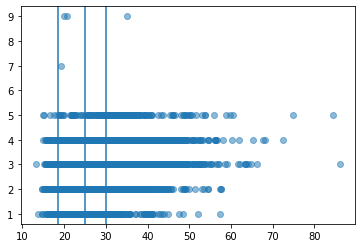

In [57]:
plt.scatter(y_df['Body Mass Index (kg/m**2)'], y_df['General health condition'], alpha=0.5)
plt.axvline(x=18.5)
plt.axvline(x=25)
plt.axvline(x=30)
plt.show()

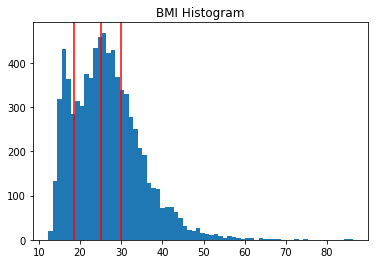

In [58]:
a = np.hstack(y_df['Body Mass Index (kg/m**2)'])
_ = plt.hist(a, bins='auto')  # arguments are passed to np.histogram
plt.axvline(x=18.5, color = 'red')
plt.axvline(x=25, color = 'red')
plt.axvline(x=30, color = 'red')
plt.title("BMI Histogram")

plt.show()

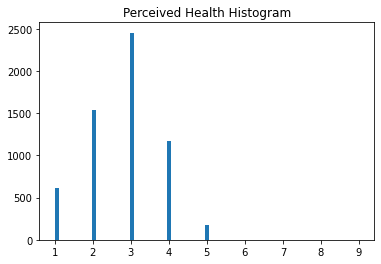

In [59]:
a = np.hstack(y_df['General health condition'])
_ = plt.hist(a, bins='auto')  # arguments are passed to np.histogram
plt.title("Perceived Health Histogram")

plt.show()

## So we see a discrepancy in how people perceive their health and their "actual" health, assuming BMI reflects people's actual health. 

## Based on X, can we classify people's perceived health and then predict their BMI?

In [60]:
X_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6161 entries, 0 to 6160
Data columns (total 70 columns):
 #   Column                                     Non-Null Count  Dtype  
---  ------                                     --------------  -----  
 0   ID                                         6161 non-null   float64
 1   Data release cycle                         6161 non-null   float64
 2   Interview/Examination status               6161 non-null   float64
 3   Gender                                     6161 non-null   float64
 4   Age in years at screening                  6161 non-null   float64
 5   Age in months at screening - 0 to 24 mos   0 non-null      float64
 6   Race/Hispanic origin                       6161 non-null   float64
 7   Race/Hispanic origin w/ NH Asian           6161 non-null   float64
 8   Six month time period                      5828 non-null   float64
 9   Age in months at exam - 0 to 19 years      557 non-null    float64
 10  Served active duty in US

In [61]:
features = ['ID',
            'HH ref person\'s gender',
            'HH ref person\'s age in years',
            'HH ref person\'s education level',
            'Race/Hispanic origin w/ NH Asian',
            'Total savings/cash assets for the family',
            'Annual family income']
features_df = X_df[features]
df = pd.merge(features_df, labels_df, on="ID")
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5417 entries, 0 to 5416
Data columns (total 9 columns):
 #   Column                                    Non-Null Count  Dtype  
---  ------                                    --------------  -----  
 0   ID                                        5417 non-null   float64
 1   HH ref person's gender                    5417 non-null   float64
 2   HH ref person's age in years              5417 non-null   float64
 3   HH ref person's education level           5181 non-null   float64
 4   Race/Hispanic origin w/ NH Asian          5417 non-null   float64
 5   Total savings/cash assets for the family  3455 non-null   float64
 6   Annual family income                      5171 non-null   float64
 7   General health condition                  5417 non-null   float64
 8   Body Mass Index (kg/m**2)                 5348 non-null   float64
dtypes: float64(9)
memory usage: 423.2 KB


# Data Cleaning

In [62]:
# Clean Data to get rid of error:
# Input contains NaN, infinity or a value too large for dtype('float32').

df.isna().sum()

ID                                             0
HH ref person's gender                         0
HH ref person's age in years                   0
HH ref person's education level              236
Race/Hispanic origin w/ NH Asian               0
Total savings/cash assets for the family    1962
Annual family income                         246
General health condition                       0
Body Mass Index (kg/m**2)                     69
dtype: int64

## So we can see that 4 columns will need cleaning.

The BMI column has 69 NaN entries, but since this is one of the labels which we are predicting, it would be better to drop these values, otherwise we may be training on egregious data.

Furthermore, the household reference person's education level is missing in 236 rows. For this we will do mode imputation because this appears to be the most reliable statistic to fill the unknown values.

For the savings & cash assets and annual income columns, it would make sense to.

**Note:** These columns (including some of the ones that do not have NaN values) also have valid values which correspond to "Refused" or "Don't know" so we will need to perform the same imputations on these entries as well in the future.


In [75]:
df[(df['Annual family income'] == 77.0) | (df['Annual family income'] == 99.0)].head(5)

,ID,HH ref person's gender,HH ref person's age in years,HH ref person's education level,Race/Hispanic origin w/ NH Asian,Total savings/cash assets for the family,Annual family income,General health condition,Body Mass Index (kg/m**2)
100,93863.0,1.0,3.0,2.0,6.0,NaN,77.0,2.0,31.6
101,93866.0,1.0,2.0,2.0,3.0,1.0,99.0,4.0,22.0
102,93868.0,1.0,4.0,1.0,4.0,NaN,77.0,4.0,35.4
111,93884.0,2.0,3.0,3.0,3.0,NaN,99.0,1.0,21.3
115,93891.0,1.0,3.0,1.0,1.0,99.0,99.0,3.0,44.6


In [81]:
print('ANNUAL FAMILY INCOME VALUES:\n', df['Annual family income'].value_counts(), sep='')

ANNUAL FAMILY INCOME VALUES:
15.0    930
6.0     583
7.0     542
14.0    476
8.0     362
5.0     349
4.0     327
9.0     301
3.0     278
10.0    238
1.0     190
2.0     172
12.0    135
99.0    115
77.0    101
13.0     72
Name: Annual family income, dtype: int64


## BMI Cleaning

In [83]:
df = df[df['Body Mass Index (kg/m**2)'].notna()]
df.isna().sum()

ID                                             0
HH ref person's gender                         0
HH ref person's age in years                   0
HH ref person's education level              232
Race/Hispanic origin w/ NH Asian               0
Total savings/cash assets for the family    1937
Annual family income                         240
General health condition                       0
Body Mass Index (kg/m**2)                      0
dtype: int64

# Modeling

In [63]:
# Convert the DataFrame to a NumPy array
df_arr = df.to_numpy()
# Segregate features and labels into separate variables
X,y = df_arr[:,1:6] , df_arr[:,7]

X_train, X_test, y_train, y_test = train_test_split(X,
                                y,
                                test_size=0.33,
                                random_state=42)
scaler = MinMaxScaler(feature_range=(0, 1))
X_train = scaler.fit_transform(X_train)
X_test = scaler.fit_transform(X_test)

clf = tree.DecisionTreeClassifier()
clf = clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
print("Accuracy of Decision Tree: ", clf.score(X_test, y_test))
print(f1_score(y_test, y_pred))

ValueError: ignored